**Muhammad Dzulfiqar Firdaus || mdzulfirdaus02@gmail.com** **|| Submission Machine Leaning ||**

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-10-21 14:35:09--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  5.54MB/s    in 49s     

2020-10-21 14:35:59 (6.25 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [3]:
#Ektraksi file rockpaperscissors
import zipfile,os
from sklearn import datasets

local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

#Split folder untuk data training dan data validation dengan ratio 6:4
!pip install split-folders
import splitfolders as sf
sf.ratio('/tmp/rockpaperscissors/rps-cv-images', output='/tmp/rockpaperscissors/data', seed=1337, ratio=(.6, .4))


Copying files: 2188 files [00:00, 2650.41 files/s]


In [4]:
#Membuat direktori path data Train dan data Valid
base_dir = '/tmp/rockpaperscissors/data'

dataTrain_dir = os.path.join(base_dir, 'train')
dataValid_dir = os.path.join(base_dir, 'val')

In [5]:
#ImageDataGenerator dan Split data train dan data validation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='wrap'
)

In [6]:
#Persiapan data training yang akan digunakan

train_gen = train_datagen.flow_from_directory(
    dataTrain_dir,              #Direktori data training
    target_size = (150, 150),   #Mengubah resolusi menjadi 150x150 pixel
    batch_size=20,
    class_mode='categorical'    #3 kelas atau lebih
)

validation_gen = train_datagen.flow_from_directory(
    dataValid_dir,                #Direktori data validation
    target_size = (150, 150),     #mengubah resolusi menjadi 150x150 pixel
    batch_size=20,
    class_mode='categorical'      #3 kelas atau lebih
)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [7]:
#membuat model
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(3, activation='softmax')
])

In [8]:
#Optimzing model

model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [9]:
#Menambahkan model Checkpoint callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger

filepath='/tmp/rockpaperscissors/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max') #menyimpan nilai akurasi tertinggi

#Membuat Logger berisi log epoch, acc, loss, val_loss, dan val_acc dalam bentuk CSV
log_csv = CSVLogger('model_log.csv', separator=',', append=False)

callback_list = [checkpoint, log_csv]

In [10]:
#Training model

train_model = model.fit(
    train_gen,
    steps_per_epoch=25,
    epochs=20,
    validation_data=validation_gen,
    validation_steps=5,
    callbacks=callback_list
)

Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.0774 - accuracy: 0.4248
Epoch 00001: val_accuracy improved from -inf to 0.77000, saving model to /tmp/rockpaperscissors/weights-improvement-01-0.77.hdf5
25/25 [==============================] - 28s 1s/step - loss: 1.0774 - accuracy: 0.4248 - val_loss: 0.8793 - val_accuracy: 0.7700
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.7500
Epoch 00002: val_accuracy improved from 0.77000 to 0.89000, saving model to /tmp/rockpaperscissors/weights-improvement-02-0.89.hdf5
25/25 [==============================] - 28s 1s/step - loss: 0.6422 - accuracy: 0.7500 - val_loss: 0.3614 - val_accuracy: 0.8900
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 0.3406 - accuracy: 0.8800
Epoch 00003: val_accuracy improved from 0.89000 to 0.91000, saving model to /tmp/rockpaperscissors/weights-improvement-03-0.91.hdf5
25/25 [==============================] - 28s 1s/step - loss: 0.3406

In [11]:
#Evaluasi model, menampilkan hasil akurasi

train_loss, train_acc = model.evaluate_generator(train_gen, steps=16)
test_loss, test_acc = model.evaluate_generator(validation_gen, steps=16)
print('Train: %.3f , Test: %.3f' % (train_acc, test_acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Train: 0.991 , Test: 0.978


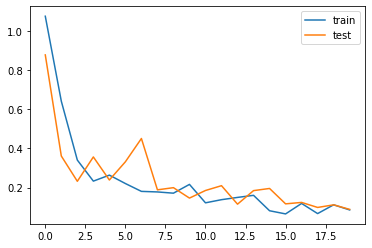

In [12]:
#Memodelkan plot loss dari training dan validation
from matplotlib import pyplot as plt
plt.plot(train_model.history['loss'], label='train')
plt.plot(train_model.history['val_loss'], label='test')
plt.legend()
plt.show()

Saving paper.png to paper.png
paper.png
Paper


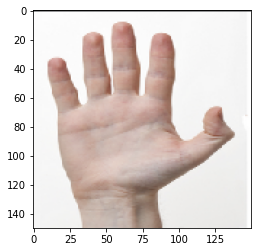

In [14]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  #prediksi citra
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes[0][0]==1:
    print('Paper')
  elif classes[0][1]==1:
    print('Rock')
  elif classes[0][2]==1:
    print('Scissor')
  else:
    print('unknown')